In [1]:
#import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist,cifar10
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt
import numpy as np

# latent layer

In [7]:
#latent layer

class LatentLayer(tf.keras.layers.Layer):
    def __init__(self, num_bits_whole, num_bits_fraction, epsilon, sensitivity, dataset_length, alpha):
        super(LatentLayer, self).__init__()
        self.num_bits_whole = num_bits_whole
        self.num_bits_fraction = num_bits_fraction
        self.epsilon = epsilon
        self.sensitivity = sensitivity
        self.dataset_length = dataset_length
        self.alpha = alpha

    def build(self, input_shape):
        self.total_bits = self.num_bits_whole + self.num_bits_fraction + 1
        self.probability = self.calculate_probability(self.epsilon, self.sensitivity, self.dataset_length) #controlling the amount of randomness
        super(LatentLayer, self).build(input_shape) #initializing the layer's weights and other operations

    def call(self, inputs):            #forward pass
        normalized_inputs = tf.image.per_image_standardization(inputs) #(x - mean) / adjusted_stddev
        binary_inputs = self._convert_to_binary(normalized_inputs)  
        randomized_inputs = self._randomize(binary_inputs) 
        return randomized_inputs

    def _convert_to_binary(self, inputs):
        whole_part = tf.cast(tf.floor(inputs), dtype=tf.int32)          #converts into int32 datatype
        fraction_part = tf.abs(inputs - tf.cast(whole_part, dtype=tf.float32)) #absolute value of input- whole part converted to float32

        binary_whole = tf.bitwise.right_shift(whole_part, self.num_bits_fraction) #divides each element by 2 ** self.num_bits_fraction
        binary_whole = tf.cast(binary_whole, dtype=tf.float32)

        binary_fraction = tf.floor(fraction_part * 2 ** self.num_bits_fraction) # fractional part is first multiplied by 2 ** self.num_bits_fraction and then round down each element
        binary_fraction = tf.cast(binary_fraction, dtype=tf.float32)

        binary_sign = tf.cast(tf.less(inputs, 0), dtype=tf.float32)  #checks each element of input is less than zero

        binary_inputs = [binary_sign, binary_whole, binary_fraction] #creates a list binary_inputs containing the sign, whole part, and fractional part of the input values, all in their binary representations

        return binary_inputs

    def _randomize(self, binary_inputs):
        merged_binary_inputs = tf.concat(binary_inputs, axis=-1)  #merges sign, whole part, and fractional part 
        randomized_inputs = self._apply_MOUE(merged_binary_inputs)
        return randomized_inputs

    def _apply_MOUE(self, merged_binary_inputs):
        alpha = self.alpha
        p0_to_1 = (alpha * tf.exp(self.epsilon / self.sensitivity)) / (1 + alpha * tf.exp(self.epsilon / self.sensitivity))
        p1_to_0 = 1 / (1 + alpha * tf.exp(self.epsilon / self.sensitivity))
        #p0_to_1 represents the probability of flipping a bit from 0 to 1, and p1_to_0 represents the probability of flipping a bit from 1 to 0.
        random_values = tf.random.uniform(tf.shape(merged_binary_inputs), minval=0.0, maxval=1.0) #generates random values of the same shape as merged_binary_inputs

        randomized_bits = tf.where(merged_binary_inputs == 1, 
                                   tf.where(random_values <= p1_to_0, 0.0, 1.0),  # #if the corresponding random value is less than or equal to p1_to_0. If it is, the bit is flipped to 0; otherwise, it remains 1
                                   tf.where(random_values <= p0_to_1, 1.0, 0.0)) #if the corresponding random value is less than or equal to p0_to_1. If it is, the bit is flipped to 1; otherwise, it remains 0.

        return randomized_bits

    @staticmethod           #directly calls the class , creating instance not reqd
    def calculate_probability(epsilon, sensitivity, dataset_length):
        return tf.exp(epsilon) / (sensitivity * dataset_length) / (1 + tf.exp(epsilon) / (sensitivity * dataset_length))

    @staticmethod
    def calculate_MOUE_probabilities(epsilon, alpha):
        p0_to_1 = 0.5
        p1_to_0 = 1 / (1 + alpha * tf.exp(epsilon))
        return p0_to_1, p1_to_0

# mnist

In [10]:
# Define the model
model = models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Max pooling
    layers.MaxPooling2D((2, 2)),
    # Dropout
    layers.Dropout(0.25),
    # Flatten layer
    layers.Flatten(),
    # Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='Adadelta',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                      

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.0

history1=model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.1)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
422/422 [==============================] - 58s 133ms/step - loss: 2.2804 - accuracy: 0.1507 - val_loss: 2.2461 - val_accuracy: 0.3665
Epoch 2/100
422/422 [==============================] - 54s 128ms/step - loss: 2.2327 - accuracy: 0.2492 - val_loss: 2.1868 - val_accuracy: 0.4908
Epoch 3/100
422/422 [==============================] - 53s 125ms/step - loss: 2.1753 - accuracy: 0.3298 - val_loss: 2.1117 - val_accuracy: 0.5902
Epoch 4/100
422/422 [==============================] - 57s 136ms/step - loss: 2.0986 - accuracy: 0.3999 - val_loss: 2.0101 - val_accuracy: 0.6562
Epoch 5/100
422/422 [==============================] - 54s 127ms/step - loss: 1.9982 - accuracy: 0.4681 - val_loss: 1.8793 - val_accuracy: 0.6993
Epoch 6/100
422/422 [==============================] - 52s 124ms/step - loss: 1.8716 - accuracy: 0.5220 - val_loss: 1.7182 - val_accuracy: 0.7378
Epoch 7/100
422/422 [==============================] - 53s 126ms/step - loss: 1.7258 - accuracy: 0.5640 - val_loss: 1.5335 -

422/422 [==============================] - 39s 93ms/step - loss: 0.4588 - accuracy: 0.8596 - val_loss: 0.2470 - val_accuracy: 0.9315
Epoch 58/100
422/422 [==============================] - 38s 91ms/step - loss: 0.4570 - accuracy: 0.8616 - val_loss: 0.2453 - val_accuracy: 0.9312
Epoch 59/100
422/422 [==============================] - 38s 89ms/step - loss: 0.4579 - accuracy: 0.8596 - val_loss: 0.2434 - val_accuracy: 0.9322
Epoch 60/100
422/422 [==============================] - 38s 90ms/step - loss: 0.4524 - accuracy: 0.8636 - val_loss: 0.2417 - val_accuracy: 0.9332
Epoch 61/100
422/422 [==============================] - 39s 93ms/step - loss: 0.4484 - accuracy: 0.8629 - val_loss: 0.2397 - val_accuracy: 0.9327
Epoch 62/100
422/422 [==============================] - 40s 95ms/step - loss: 0.4476 - accuracy: 0.8637 - val_loss: 0.2378 - val_accuracy: 0.9340
Epoch 63/100
422/422 [==============================] - 39s 92ms/step - loss: 0.4407 - accuracy: 0.8652 - val_loss: 0.2357 - val_accuracy

# mnist using dp

In [12]:
input_shape = (28, 28, 1)
num_bits_whole = 4
num_bits_fraction = 5
epsilon = 2.0
sensitivity = 2  # Assuming sensitivity of 2
dataset_length = len(x_train)
num_classes = 10
alpha = 8  # Adjust alpha value

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    LatentLayer(num_bits_whole, num_bits_fraction, epsilon, sensitivity, dataset_length, alpha),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])



model.compile(optimizer='adadelta',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 latent_layer_1 (LatentLaye  (None, 12, 12, 192)       0         
 r)                                                              
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 64)        110656    
                                                                 
 flatten_3 (Flatten)         (None, 6400)             

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.0

history = History()

history2=model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.1,callbacks=[history])

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
422/422 [==============================] - 46s 106ms/step - loss: 2.5570 - accuracy: 0.1008 - val_loss: 2.3204 - val_accuracy: 0.0943
Epoch 2/100
422/422 [==============================] - 45s 106ms/step - loss: 2.3403 - accuracy: 0.1015 - val_loss: 2.3095 - val_accuracy: 0.1013
Epoch 3/100
422/422 [==============================] - 45s 107ms/step - loss: 2.3132 - accuracy: 0.1028 - val_loss: 2.3054 - val_accuracy: 0.1012
Epoch 4/100
422/422 [==============================] - 45s 107ms/step - loss: 2.3072 - accuracy: 0.1012 - val_loss: 2.3034 - val_accuracy: 0.1022
Epoch 5/100
422/422 [==============================] - 45s 106ms/step - loss: 2.3037 - accuracy: 0.1038 - val_loss: 2.3016 - val_accuracy: 0.1112
Epoch 6/100
422/422 [==============================] - 45s 107ms/step - loss: 2.3039 - accuracy: 0.1058 - val_loss: 2.3036 - val_accuracy: 0.0990
Epoch 7/100
422/422 [==============================] - 44s 105ms/step - loss: 2.3032 - accuracy: 0.1054 - val_loss: 2.3031 -

# Classification Rate Comparison - MNIST

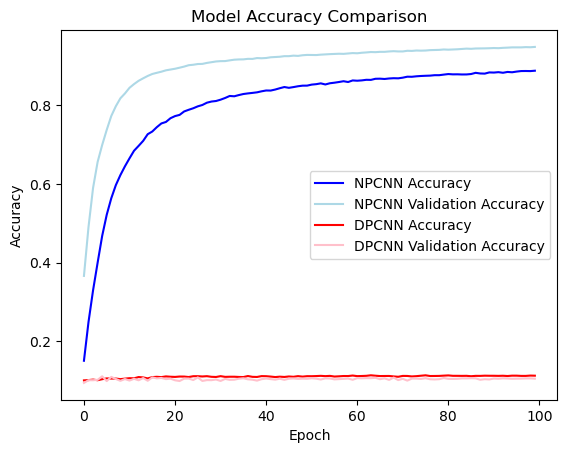

In [18]:
plt.plot(history1.history['accuracy'], label='NPCNN Accuracy', color='blue')
plt.plot(history1.history['val_accuracy'], label='NPCNN Validation Accuracy', color='lightblue')
plt.plot(history2.history['accuracy'], label='DPCNN Accuracy', color='red')
plt.plot(history2.history['val_accuracy'], label='DPCNN Validation Accuracy', color='pink')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# cifar-10

In [13]:
# Define the model
model = models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    # Max pooling
    layers.MaxPooling2D((2, 2)),
    # Dropout
    layers.Dropout(0.25),
    # Convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Max pooling
    layers.MaxPooling2D((2, 2)),
    # Dropout
    layers.Dropout(0.25),
    # Flatten layer
    layers.Flatten(),
    # Dense layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 10, 64)        36928     
                                                      

In [14]:
# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


# Train the model
history1=model.fit(x_train, y_train, epochs=100, batch_size=500, validation_split=0.1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
90/90 [==============================] - 31s 333ms/step - loss: 1.8870 - accuracy: 0.3026 - val_loss: 1.5390 - val_accuracy: 0.4420
Epoch 2/100
90/90 [==============================] - 37s 416ms/step - loss: 1.5082 - accuracy: 0.4497 - val_loss: 1.3320 - val_accuracy: 0.5170
Epoch 3/100
90/90 [==============================] - 35s 391ms/step - loss: 1.3602 - accuracy: 0.5101 - val_loss: 1.2435 - val_accuracy: 0.5566
Epoch 4/100
90/90 [==============================] - 30s 333ms/step - loss: 1.2553 - accuracy: 0.5511 - val_loss: 1.1444 - val_accuracy: 0.5930
Epoch 5/100
90/90 [==============================] - 30s 330ms/step - loss: 1.1812 - accuracy: 0.5801 - val_loss: 1.0666 - val_accuracy: 0.6266
Epoch 6/100
90/90 [==============================] - 30s 332ms/step - loss: 1.1185 - accuracy: 0.6052 - val_loss: 1.0211 - val_accuracy: 0.6436
Epoch 7/100
90/90 [==============================] - 30s 338ms/step - loss: 1.0597 - accuracy: 0.6257 - val_loss: 0.9515 - val_accuracy:

# cifar-10 using dp

In [5]:
input_shape = (32, 32, 3)  # CIFAR-10 images are 32x32 with 3 channels
num_bits_whole = 2
num_bits_fraction = 7
epsilon = 2.0
sensitivity = 2  # Assuming sensitivity of 2
dataset_length = len(x_train)
num_classes = 10
alpha = 8  # Adjust alpha value as needed

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    LatentLayer(num_bits_whole, num_bits_fraction, epsilon, sensitivity, dataset_length, alpha),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 latent_layer (LatentLayer)  (None, 14, 14, 192)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        110656    
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 64)        36928     
                                                      

In [9]:
# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

history = History()

# Train the model
history2=model.fit(x_train, y_train, epochs=100, batch_size=500, validation_split=0.1, callbacks=[history])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
90/90 [==============================] - 83s 898ms/step - loss: 2.3183 - accuracy: 0.1002 - val_loss: 2.3027 - val_accuracy: 0.0976
Epoch 2/100
90/90 [==============================] - 54s 603ms/step - loss: 2.3026 - accuracy: 0.0985 - val_loss: 2.3027 - val_accuracy: 0.0950
Epoch 3/100
90/90 [==============================] - 58s 641ms/step - loss: 2.3026 - accuracy: 0.1004 - val_loss: 2.3028 - val_accuracy: 0.0958
Epoch 4/100
90/90 [==============================] - 59s 656ms/step - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3028 - val_accuracy: 0.0976
Epoch 5/100
90/90 [==============================] - 52s 574ms/step - loss: 2.3026 - accuracy: 0.0991 - val_loss: 2.3029 - val_accuracy: 0.0950
Epoch 6/100
90/90 [==============================] - 50s 556ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3028 - val_accuracy: 0.0950
Epoch 7/100
90/90 [==============================] - 52s 581ms/step - loss: 2.3026 - accuracy: 0.1014 - val_loss: 2.3028 - val_accuracy:

Epoch 51/100
90/90 [==============================] - 50s 553ms/step - loss: 2.3026 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.0950
Epoch 52/100
90/90 [==============================] - 56s 622ms/step - loss: 2.3026 - accuracy: 0.0987 - val_loss: 2.3028 - val_accuracy: 0.0970
Epoch 53/100
90/90 [==============================] - 55s 613ms/step - loss: 2.3026 - accuracy: 0.0982 - val_loss: 2.3028 - val_accuracy: 0.0950
Epoch 54/100
90/90 [==============================] - 52s 577ms/step - loss: 2.3026 - accuracy: 0.1006 - val_loss: 2.3028 - val_accuracy: 0.0970
Epoch 55/100
90/90 [==============================] - 53s 595ms/step - loss: 2.3026 - accuracy: 0.0970 - val_loss: 2.3028 - val_accuracy: 0.0958
Epoch 56/100
90/90 [==============================] - 55s 612ms/step - loss: 2.3026 - accuracy: 0.0994 - val_loss: 2.3028 - val_accuracy: 0.0950
Epoch 57/100
90/90 [==============================] - 55s 615ms/step - loss: 2.3026 - accuracy: 0.0998 - val_loss: 2.3028 - val_ac

# Classification Rate Comparison - CIFAR10

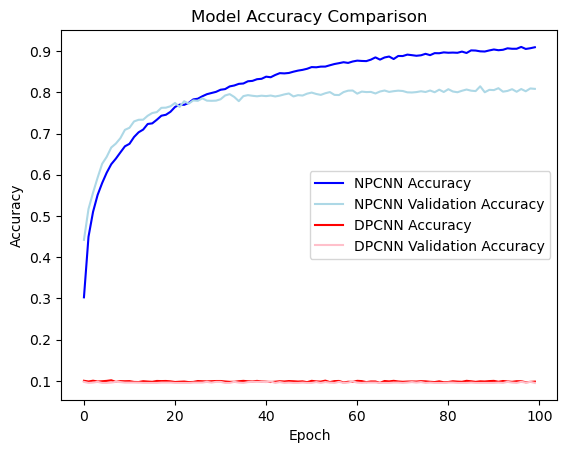

In [15]:
plt.plot(history1.history['accuracy'], label='NPCNN Accuracy', color='blue')
plt.plot(history1.history['val_accuracy'], label='NPCNN Validation Accuracy', color='lightblue')
plt.plot(history2.history['accuracy'], label='DPCNN Accuracy', color='red')
plt.plot(history2.history['val_accuracy'], label='DPCNN Validation Accuracy', color='pink')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()